In [1]:
from glob import glob
import os, cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from keras.layers import Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras.utils.vis_utils import plot_model
from IPython.display import clear_output

In [2]:
## define params

DIR = "koeln"
SEED = 650
IMG_SIZE = 256
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE = 8
NUM_CLASSES = 10

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# for file in os.listdir(DIR):
#     if file.endswith(".jp2"):
#         img = Image.open(os.dir.join(DIR,file))
#         img.save(os.path.join(DIR,file[0:-4] + ".png"))

In [4]:
def load_data(dir):
    images = glob(os.path.join(dir, "image\\*.png"))
    masks = glob(os.path.join(dir, "mask\\*.tif"))

    return images, masks

def read_image(dir):
    x = cv2.imread(dir, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMG_SIZE, IMG_SIZE))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(dir):
    x = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMG_SIZE, IMG_SIZE))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.float32)
    return x
    
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([IMG_SIZE, IMG_SIZE, 3])
    masks.set_shape([IMG_SIZE, IMG_SIZE, 1])

    return images, masks


In [5]:
images, masks = load_data(DIR)
print(f"Images: {len(images)} - Masks: {len(masks)}")

LEN_DATA = len(images)

geonrw = tf.data.Dataset.from_tensor_slices((images, masks))
geonrw = geonrw.shuffle(buffer_size=LEN_DATA)
geonrw = geonrw.map(preprocess)
geonrw = geonrw.batch(BATCH_SIZE)
geonrw = geonrw.prefetch(buffer_size=AUTOTUNE)

Images: 479 - Masks: 479


In [6]:
geonrw_tr = geonrw.take(int(LEN_DATA / BATCH_SIZE * 0.7))
geonrw_te = geonrw.skip(int(LEN_DATA / BATCH_SIZE * 0.7))

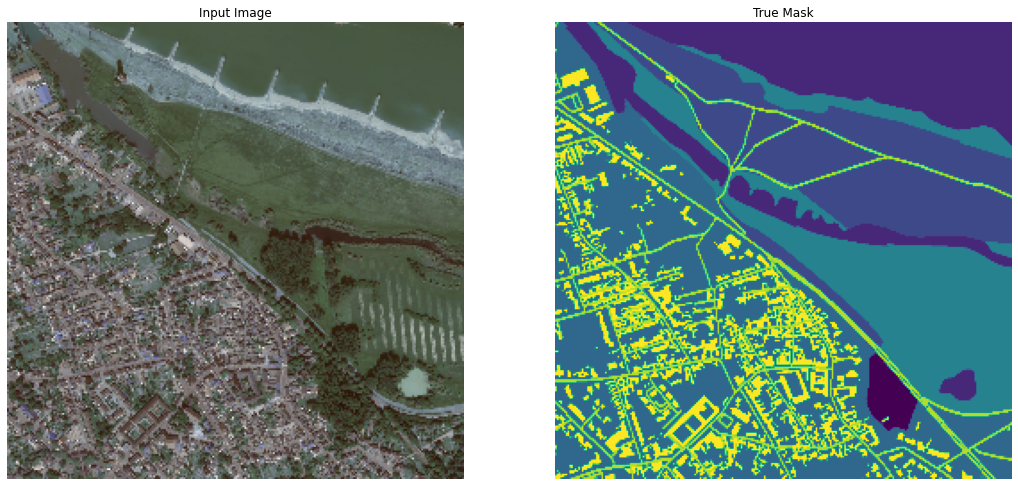

In [7]:
def display_sample(display_list):

    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
for image, mask in geonrw_tr.take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

In [8]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [9]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPooling2D(2)(f)
   p = Dropout(0.3)(p)
   return f, p

In [10]:
def upsample_block(x, conv_features, n_filters):
   x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = concatenate([x, conv_features])
   x = Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [11]:
def build_unet():
    # inputs
    inputs = Input(shape=(INPUT_SHAPE))
    # encoder: contracting dir - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding dir - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [12]:
model = build_unet()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [13]:
# from numba import cuda
# cuda.get_current_device().reset()

In [15]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])
for image, mask in geonrw_tr.take(1):
    sample_image, sample_mask = image, mask

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

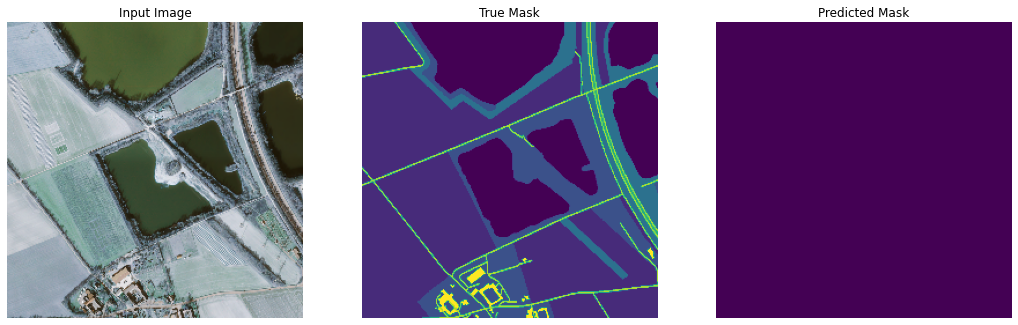


Sample Prediction after epoch 6


Epoch 6: val_loss did not improve from 0.00000
41/41 [==============================] - 31s 769ms/step - loss: 1.0397e-08 - accuracy: 0.0000e+00 - val_loss: 4.8185e-13 - val_accuracy: 0.0000e+00
Epoch 7/20
41/41 [==============================] - ETA: 0s - loss: 3.6969e-06 - accuracy: 0.0000e+00

In [16]:
NUM_EPOCHS = 20
TRAIN_SIZE = len(geonrw_tr)
TEST_SIZE = len(geonrw_te)
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # to show samples after each epoch
    DisplayCallback(),
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

model_history = model.fit(geonrw_tr,
                          epochs=NUM_EPOCHS,
                        #   steps_per_epoch=STEPS_PER_EPOCH,
                        #   validation_steps=VALIDATION_STEPS,
                          validation_data=geonrw_te,
                          verbose=1,
                          callbacks=callbacks)